In [2]:
import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd

# Question 2.4

In [3]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [40]:
import numpy as np

def load_data(log_file, value='Eval_AverageReturn', data='Train_EnvstepsSoFar'):
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()
    values = event_acc.Scalars(value)
    if data:
        env_steps = [
            e.value for e in event_acc.Scalars(data)
        ]
    else:
        env_steps = [
            e.step for e in values
        ]
    values = [
        e.value for e in event_acc.Scalars(value)
    ]

    return np.array(env_steps), np.array(values)

In [5]:
def plot(log_file, value='Eval_AverageReturn'):
    x, y = load_data(log_file, value = value, data = None)
    plt.plot(x,y)
    plt.xlabel("timesteps")
    plt.ylabel(value)

In [29]:
# Do not run, this will mess up the indices used later
experiment_paths = sorted([os.path.join("data_exp", filename) for filename in os.listdir("data_exp")])
baseline_paths = sorted([os.path.join("data", filename) for filename in os.listdir("data")])

In [30]:
print(len(experiment_paths))
print(len(baseline_paths))
for i, path in enumerate(experiment_paths):
    # print(i, ": ", path)
    pass

675
225


In [31]:
import re

def search_strings(strings, pattern_dict):
    result = []
    
    for s in strings:
        matches = []
        for key, value in pattern_dict.items():
            pattern = fr'{re.escape(key)}_{re.escape(str(value))}'
            if re.search(pattern, s):
                matches.append(True)
            else:
                matches.append(False)
        
        if all(matches):
            result.append(s)
    
    return result

best_baseline_params = {"schedule_timesteps": 10000, "final_p": 0.02, "initial_p": 1.0, "schedule_type": "linear", "lr": 0.1, "batch_size": 100, "base_config": "dqn_basic", "env_name": "CartPole-v1", "target_update_period": 1000, "total_steps": 10000}
best_baseline_paths = search_strings(baseline_paths, best_baseline_params)
print(best_baseline_paths)

best_exp_params = {"alpha": 0.4, "n": 10000, "p": 0.1, "threshold": 0.2, "eps_max": 0.3, "schedule_type": "adaptive", "lr": 0.001, "batch_size": 10, "base_config": "dqn_basic", "env_name": "CartPole-v1", "target_update_period": 1000, "total_steps": 10000}
best_exp_paths = search_strings(experiment_paths, best_exp_params)
print(best_exp_paths)

['data/hw3_dqn_lr_0.1_batch_size_100_base_config_dqn_basic_env_name_CartPole-v1_target_update_period_1000_total_steps_10000_schedule_timesteps_10000_final_p_0.02_initial_p_1.0_schedule_type_linear_CartPole-v1_s64_l2_d0.99_seed_1_06-12-2023_16-31-55', 'data/hw3_dqn_lr_0.1_batch_size_100_base_config_dqn_basic_env_name_CartPole-v1_target_update_period_1000_total_steps_10000_schedule_timesteps_10000_final_p_0.02_initial_p_1.0_schedule_type_linear_CartPole-v1_s64_l2_d0.99_seed_1_06-12-2023_16-36-25', 'data/hw3_dqn_lr_0.1_batch_size_100_base_config_dqn_basic_env_name_CartPole-v1_target_update_period_1000_total_steps_10000_schedule_timesteps_10000_final_p_0.02_initial_p_1.0_schedule_type_linear_CartPole-v1_s64_l2_d0.99_seed_2_06-12-2023_16-31-55', 'data/hw3_dqn_lr_0.1_batch_size_100_base_config_dqn_basic_env_name_CartPole-v1_target_update_period_1000_total_steps_10000_schedule_timesteps_10000_final_p_0.02_initial_p_1.0_schedule_type_linear_CartPole-v1_s64_l2_d0.99_seed_2_06-12-2023_16-36-24',

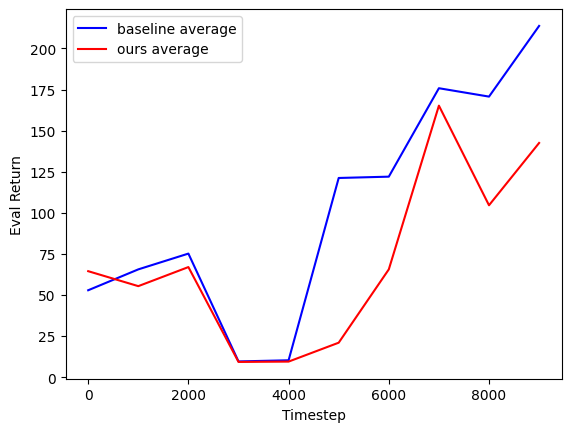

In [46]:
for p in best_baseline_paths:
    total_x, total_y = [], []
    for f in os.listdir(p):
        cartpole_file = os.path.join(p, f)
        x, y = load_data(cartpole_file, value = "eval_return", data = None)
        total_x.append(x)
        total_y.append(y)
        # plt.plot(x, y, "b", label="baseline")

x, y = sum(total_x) / len(total_x), sum(total_y) / len(total_y)
plt.plot(x, y, "b", label="baseline average")
    
for p in best_exp_paths:
    total_x, total_y = [], []
    for f in os.listdir(p):
        cartpole_file = os.path.join(p, f)
        x, y = load_data(cartpole_file, value = "eval_return", data = None)
        total_x.append(x)
        total_y.append(y)
        # plt.plot(x, y, "b", label="baseline")

x, y = sum(total_x) / len(total_x), sum(total_y) / len(total_y)
plt.plot(x, y, "r", label="ours average")
plt.xlabel("Timestep")
plt.ylabel("Eval Return")
plt.legend()


## Changing learning rate for cartpole

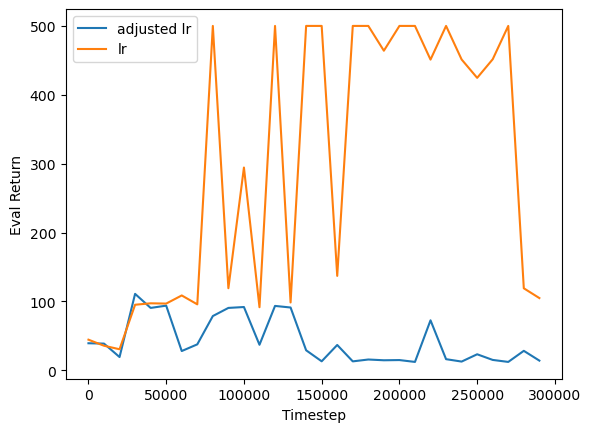

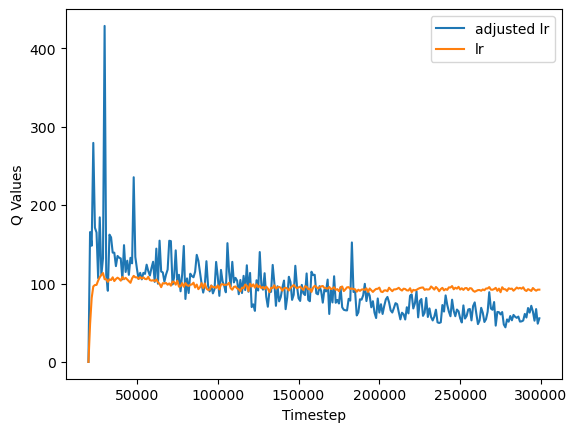

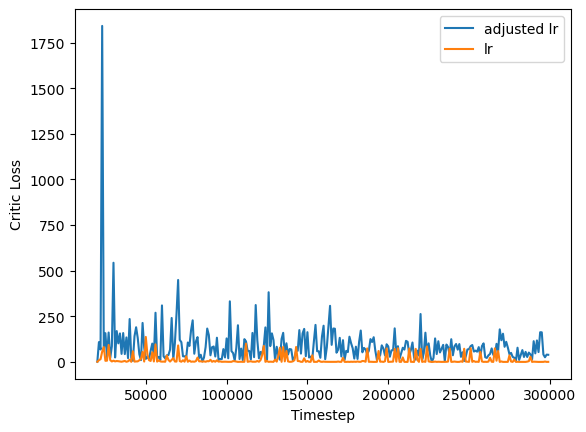

In [217]:
cartpole_lr_path = experiment_paths[7]
for f in os.listdir(cartpole_lr_path):
    cartpole_lr_file = os.path.join(cartpole_lr_path, f)
    x, y = load_data(cartpole_lr_file, value = "eval_return", data = None)
    plt.plot(x,y, label = 'adjusted lr')
    x, y = load_data(cartpole_file, value = "eval_return", data = None)
    plt.plot(x,y, label = 'lr')
    plt.xlabel("Timestep")
    plt.ylabel("Eval Return")
    plt.legend()
    plt.show()
    x, y = load_data(cartpole_lr_file, value = "q_values", data = None)
    plt.plot(x,y, label = 'adjusted lr')
    x, y = load_data(cartpole_file, value = "q_values", data = None)
    plt.plot(x,y, label = 'lr')
    plt.xlabel("Timestep")
    plt.ylabel("Q Values")
    plt.legend()
    plt.show()
    x, y = load_data(cartpole_lr_file, value = "critic_loss", data = None)
    plt.plot(x,y, label = 'adjusted lr')
    x, y = load_data(cartpole_file, value = "critic_loss", data = None)
    plt.plot(x,y, label = 'lr')
    plt.xlabel("Timestep")
    plt.ylabel("Critic Loss")
    plt.legend()
    plt.show()

The Q values start higher but drop lower, and the critic error is worse pretty much all the time. I think this is because when the learning rate is high the critic is changing too quickly, and so the targets end up changing too quickly (especially right after we update the target network).

# Q2.5

In [218]:
lunar_lander_paths = experiment_paths[16:19]
lunar_lander_doubleq_paths = experiment_paths[19:22]
lunar_lander_files = []
lunar_lander_doubleq_files = []
for lunar_lander in lunar_lander_paths:
    for f in os.listdir(lunar_lander):
        lunar_lander_files.append(os.path.join(lunar_lander, f))
for lunar_lander in lunar_lander_doubleq_paths:
    for f in os.listdir(lunar_lander):
        lunar_lander_doubleq_files.append(os.path.join(lunar_lander, f))

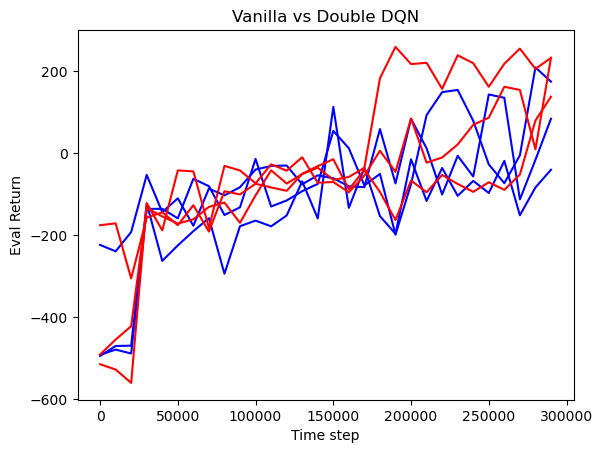

In [219]:
for f in lunar_lander_files:
    x, y = load_data(f, 'eval_return', data = None)
    plt.plot(x,y, color = 'blue')
for f in lunar_lander_doubleq_files:
    x, y = load_data(f, 'eval_return', data = None)
    plt.plot(x,y, color = 'red')
plt.title('Vanilla vs Double DQN')
plt.xlabel('Time step')
plt.ylabel('Eval Return');


I think the double DQN does better because the policy isn't fooled by the (postive) errors that the critic makes.

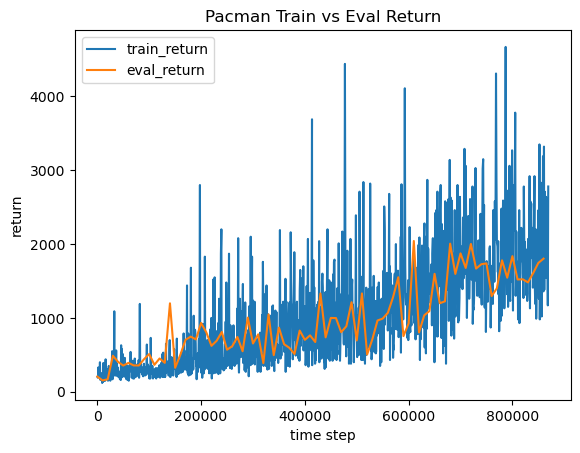

In [220]:
pacman_path = experiment_paths[12]
for f in os.listdir(pacman_path):
    pacman_file = os.path.join(pacman_path, f)
x, y = load_data(pacman_file, 'train_return', data = None)
plt.plot(x,y, label = 'train_return')
plt.xlabel('time step')
plt.ylabel('return')
plt.title('Pacman Train vs Eval Return')
x, y = load_data(pacman_file, 'eval_return', data = None)
plt.plot(x,y, label = 'eval_return')
plt.legend()
plt.show()

The train return doesn't look very differnt from the eval return early on to me, just noiser. If we smoothened the train eval out it seems like maybe the eval return is increasing much much faster at the beginning than the train eval. I think this might just be because during training some of the Q Values we predict are noiser than others, so some end up with (positive) errors that fool our policy, whereas during eval everything is noisy and so whatever the best actions are one of them will probably have positive error and get picked, and then as we train our Q function more we stop running into that problem, which is why it only looks like that at the beginning.

# Q2.6

In [221]:
cartpole_files

['data/hw3_dqn_Cartpole_CartPole-v1_s64_l2_d0.99_18-10-2023_21-32-21/events.out.tfevents.1697689941.wifi-10-40-18-67.wifi.berkeley.edu',
 'data/hw3_dqn_Cartpole_discount2_CartPole-v1_s64_l2_d0.9_21-10-2023_16-12-43/events.out.tfevents.1697929963.Jonathans-MacBook-Pro.local',
 'data/hw3_dqn_Cartpole_discount3_CartPole-v1_s64_l2_d0.999_21-10-2023_16-12-43/events.out.tfevents.1697929963.Jonathans-MacBook-Pro.local',
 'data/hw3_dqn_Cartpole_discount4_CartPole-v1_s64_l2_d0.6_21-10-2023_16-12-43/events.out.tfevents.1697929963.Jonathans-MacBook-Pro.local']

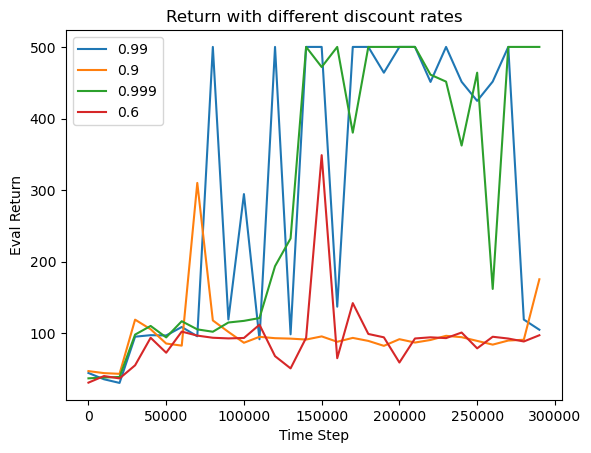

In [222]:
cartpole_paths = experiment_paths[3:7]
cartpole_files = []
for c in cartpole_paths:
    for f in os.listdir(c):
        cartpole_files.append(os.path.join(c,f))
discounts = ['0.99', '0.9', '0.999', '0.6']
for i, f in enumerate(cartpole_files):
    x, y = load_data(f, value = "eval_return", data = None)
    plt.plot(x,y,label = discounts[i])
plt.xlabel('Time Step')
plt.ylabel('Eval Return')
plt.title('Return with different discount rates')
plt.legend();
        

I chose to vary the discount rate because I thought it shouldn't really make a difference for the cartpole problem, the strategy should never change no matter how much you discount the future you always just want to keep the pole up, but it turns out it does actually have a huge affect on our outcome which is interesting to me.

# Q3.1.3

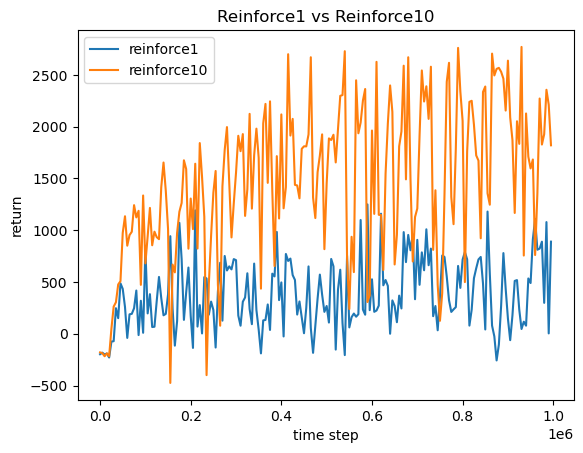

In [223]:
reinforce1_path = experiment_paths[23]
reinforce10_path = experiment_paths[22]
for f in os.listdir(reinforce1_path):
    reinforce1_file = os.path.join(reinforce1_path, f)
for f in os.listdir(reinforce10_path):
    reinforce10_file = os.path.join(reinforce10_path, f)
x, y = load_data(reinforce1_file, 'eval_return', data = None)
plt.plot(x,y, label = 'reinforce1')
plt.xlabel('time step')
plt.ylabel('return')
plt.title('Reinforce1 vs Reinforce10')
x, y = load_data(reinforce10_file, 'eval_return', data = None)
plt.plot(x,y, label = 'reinforce10')
plt.legend()
plt.show()

They are kinda similar but the 10 sample version does much better, I think this is just because we are trying to estimate an expectation to come up with our gradient, and the quality of our esimate is increased as we take more samples.

# Q3.1.4

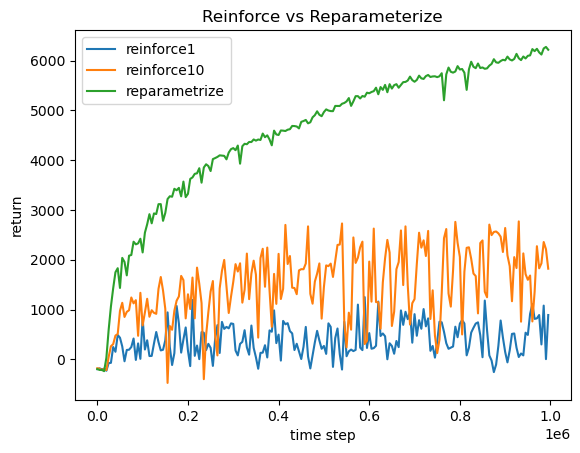

In [224]:
reparametrize_path = experiment_paths[24]
for f in os.listdir(reparametrize_path):
    reparametrize_file = os.path.join(reparametrize_path, f)
x, y = load_data(reinforce1_file, 'eval_return', data = None)
plt.plot(x,y, label = 'reinforce1')
plt.xlabel('time step')
plt.ylabel('return')
plt.title('Reinforce vs Reparameterize')
x, y = load_data(reinforce10_file, 'eval_return', data = None)
plt.plot(x,y, label = 'reinforce10')
x, y = load_data(reparametrize_file, 'eval_return', data = None)
plt.plot(x,y, label = 'reparametrize')
plt.legend();



# Q3.1.5

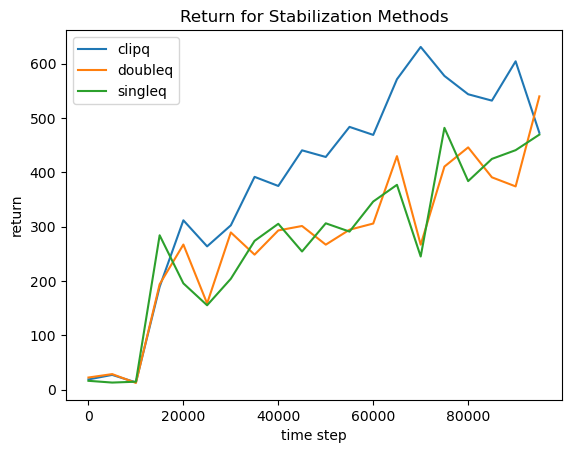

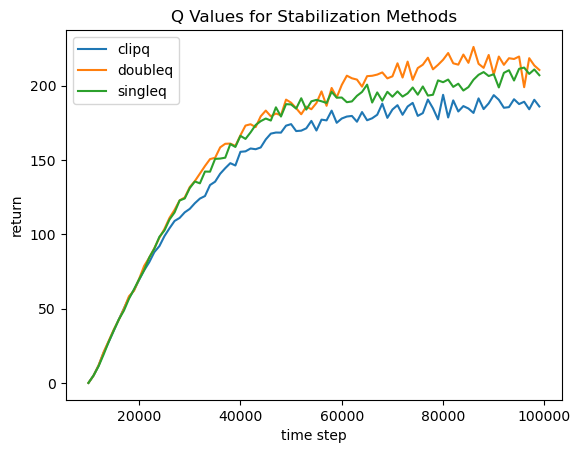

In [226]:
hopper_paths = experiment_paths[25:29]
hopper_paths.pop(1)
hopper_files = []
for hopper in hopper_paths:
    for f in os.listdir(hopper):
        hopper_files.append(os.path.join(hopper,f))
x, y = load_data(hopper_files[0], 'eval_return', data = None)
plt.plot(x,y, label = 'clipq')
plt.xlabel('time step')
plt.ylabel('return')
plt.title('Return for Stabilization Methods')
x, y = load_data(hopper_files[1], 'eval_return', data = None)
plt.plot(x,y, label = 'doubleq')
x, y = load_data(hopper_files[2], 'eval_return', data = None)
plt.plot(x,y, label = 'singleq')
plt.legend()
plt.show()
x, y = load_data(hopper_files[0], 'q_values', data = None)
plt.plot(x,y, label = 'clipq')
plt.xlabel('time step')
plt.ylabel('return')
plt.title('Q Values for Stabilization Methods')
x, y = load_data(hopper_files[1], 'q_values', data = None)
plt.plot(x,y, label = 'doubleq')
x, y = load_data(hopper_files[2], 'q_values', data = None)
plt.plot(x,y, label = 'singleq')
plt.legend();

Clip Q seems to work best, double and single Q get pretty similar results. I think this is because clip Q is very pessimistic, so it's hard to fool it into thinking a bad action is good, since we just learn lower Q values for every sitation, so even if unseen points have highly positive errors it is still probably below what the true Q value is. In single Q we don't really take any precautions, but I think even though we are usign two networks in double Q, if one happens to highly overestimate then the other network will use that as a target and so it will raise it's estimate and overestimate, so it may lead to some Q values being high where they shouldn't be.

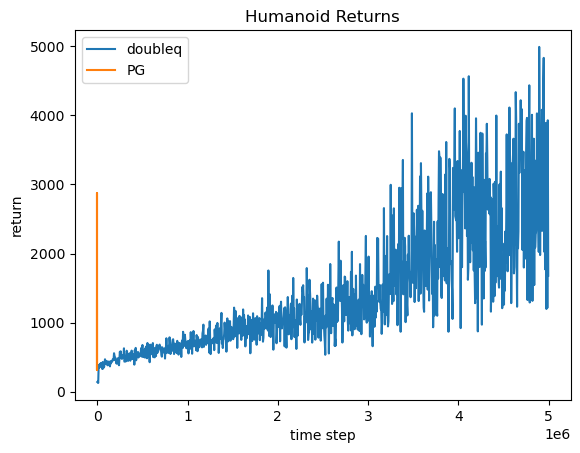

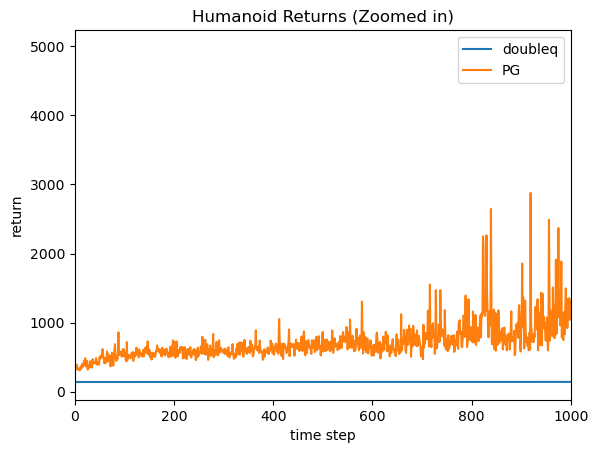

In [227]:
humanoid_path = experiment_paths[35]
for f in os.listdir(humanoid_path):
    humanoid_file = os.path.join(humanoid_path, f)
comparison_file = experiment_paths[2]
x, y = load_data(humanoid_file, 'eval_return', data = None)
plt.plot(x,y, label = 'doubleq')
plt.xlabel('time step')
plt.ylabel('return')
plt.title('Humanoid Returns')
x, y = load_data(comparison_file, 'Eval_AverageReturn', data = None)
plt.plot(x,y, label = 'PG')
plt.legend()
plt.show()
x, y = load_data(humanoid_file, 'eval_return', data = None)
plt.plot(x,y, label = 'doubleq')
plt.xlabel('time step')
plt.ylabel('return')
plt.title('Humanoid Returns (Zoomed in)')
x, y = load_data(comparison_file, 'Eval_AverageReturn', data = None)
plt.plot(x,y, label = 'PG')
plt.xlim(left = 0, right = 1000)
plt.legend()
plt.show()


The on policy algorithm is much more sample efficient, we can see it quickly achives better results. 